<a href="https://colab.research.google.com/github/TongleiChen/sketch_to_image/blob/main/sketchtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
from io import BytesIO # Use When expecting bytes-like objects
import pickle
from collections import OrderedDict
import os
from os import path
import ast
import random

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageOps

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import os
import matplotlib.pyplot as plt

# from torch_snippets import *
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms



from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@title SKETCH CLASSIFICATION
categories = ["bear","camel","cat","dog","elephant","frog","lion","panda","rabbit","squirrel"]
# categories = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_dict = {0:'bear',1:'camel',2:'cat', 3:'dog', 4:'elephant',
                      5:'frog',6:'lion', 7:'panda', 8:'rabbit', 9:'squirrel'}

# load data for each category
classes = {}
for category in categories:
    # ctl's path
    #data = pd.read_csv("./drive/MyDrive/kaggle/sketch/" + category + ".csv")
    # lzx's path
    data = pd.read_csv("./drive/MyDrive/sketch/" + category + ".csv")
    classes[category] = data

In [ ]:
# Image manipulation utilities: 

def convert_to_PIL(drawing, width = 256, height = 256):
    """
    Function to convert from drawing to PIL image.
    INPUT:
        drawing - drawing from 'drawing' column
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        pil_img - (PIL Image) image
    """
    
    # initialize empty (white) PIL image
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()
            
    draw = ImageDraw.Draw(pil_img)
    
    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)
        
    return pil_img


def convert_to_np_raw(drawing, width = 256, height = 256):
    """
    INPUT:
        drawing - drawing in initial format
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        img - drawing converted to the numpy array (28 X 28)
    """
    # initialize empty numpy array
    img = np.zeros((28, 28))
    
    # create a PIL image out of drawing
    pil_img = convert_to_PIL(drawing)
    
    #resize to 28,28
    pil_img.thumbnail((28,28), Image.ANTIALIAS)
    
    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()

    # fill in numpy array with pixel values
    for i in range(0, 28):
        for j in range(0, 28):
            img[i, j] = 1 - pixels[j, i][0] / 255
    
    return img

def convert_to_np(pil_img, width = 256, height = 256):
    """
    Function to convert PIL Image to numpy array.
    INPUT:
        pil_img - (PIL Image) image to be converted
    OUTPUT:
        img - (numpy array) converted image with shape (width, height)
    """
    pil_img = pil_img.convert('RGB')

    img = np.zeros((width, height))
    pixels = pil_img.load()

    for i in range(0, width):
      for j in range(0, height):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img

def view_image(img, width = 256, height = 256):
    """
    Function to view numpy image with matplotlib.
    The function saves the image as png.
    INPUT:
        img - (numpy array) image from train dataset with size (1, 784)
    OUTPUT:
    None
    """
    fig, ax = plt.subplots(figsize=(6,9))
    ax.imshow(img.reshape(width, height).squeeze())
    ax.axis('off')

    plt.show()
def crop_image(image):
    """
    Crops image (crops out white spaces).
    INPUT:
        image - PIL image of original size to be cropped
    OUTPUT:
        cropped_image - PIL image cropped to the center  and resized to (28, 28)
    """
    cropped_image = image

    # get image size
    width, height = cropped_image.size

    # get image pixels
    pixels = cropped_image.load()

    image_strokes_rows = []
    image_strokes_cols = []

    # run through the image
    for i in range(0, width):
        for j in range(0, height):
            # save coordinates of the image
            if (pixels[i,j][0] > 0):
                image_strokes_cols.append(i)
                image_strokes_rows.append(j)

    # if image is not empty then crop to contents of the image
    if (len(image_strokes_rows)) > 0:
        # find the box for image
        row_min = np.array(image_strokes_rows).min()
        row_max = np.array(image_strokes_rows).max()
        col_min = np.array(image_strokes_cols).min()
        col_max = np.array(image_strokes_cols).max()

        # find the box for cropping
        margin = min(row_min, height - row_max, col_min, width - col_max)

        # crop image
        border = (col_min, row_min, width - col_max, height - row_max)
        cropped_image = ImageOps.crop(cropped_image, border)

    # get cropped image size
    width_cropped, height_cropped = cropped_image.size

    # create square resulting image to paste cropped image into the center
    dst_im = Image.new("RGBA", (max(width_cropped, height_cropped), max(width_cropped, height_cropped)), "white")
    offset = ((max(width_cropped, height_cropped) - width_cropped) // 2, (max(width_cropped, height_cropped) - height_cropped) // 2)
    # paste to the center of a resulting image
    dst_im.paste(cropped_image, offset)

    #resize to 28,28
    dst_im.thumbnail((28,28), Image.ANTIALIAS)
    
    return dst_im
def normalize(arr):
    """
    Function performs the linear normalizarion of the array.
    https://stackoverflow.com/questions/7422204/intensity-normalization-of-image-using-pythonpil-speed-issues
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    INPUT:
        arr - orginal numpy array
    OUTPUT:
        arr - normalized numpy array
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def normalize_image(image):
    """
    Function performs the normalization of the image.
    https://stackoverflow.com/questions/7422204/intensity-normalization-of-image-using-pythonpil-speed-issues
    INPUT:
        image - PIL image to be normalized
    OUTPUT:
        new_img - PIL image normalized
    """
    arr = np.array(image)
    new_img = Image.fromarray(normalize(arr).astype('uint8'),'RGBA')
    return new_img

def rotate_image(src_im, angle = 45, size = (28,28)):
    """
    Function to rotate PIL Image file
    INPUT:
        src_im - (PIL Image) 28x28 image to be rotated
        angle - angle to rotate the image
        size - (tuple) size of the output image
    OUTPUT:
    dst_im - (PIL Image) rotated image
    """
    dst_im = Image.new("RGBA", size, "white")
    src_im = src_im.convert('RGBA')

    rot = src_im.rotate(angle)
    dst_im.paste(rot, (0, 0), rot)

    return dst_im
def flip_image(src_im):
    """
    Function to flip a PIL Image file.
    INPUT:
        scr_im - (PIL Image) image to be flipped
    OUTPUT:
        dst_im - (PIL Image) flipped image
    """
    dst_im = src_im.transpose(Image.FLIP_LEFT_RIGHT)
    return dst_im


In [ ]:
# shrinking the images

# create the dictionary containing classes names as keys and images as values
values_dict = {}
for category in categories:
    data = classes[category][:3000]
    values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    values_dict[category] = values
    
# concatenate to create X (values) and y (labels) datasets
X = []
y = []

for key, value in label_dict.items():
    data_i = values_dict[value]
    Xi = np.concatenate(data_i, axis = 0)
    yi = np.full((len(Xi), 1), key).ravel()
    
    X.append(Xi)
    y.append(yi)
X = np.concatenate(X, axis = 0)
#print(X.shape)
y = np.concatenate(y, axis = 0)

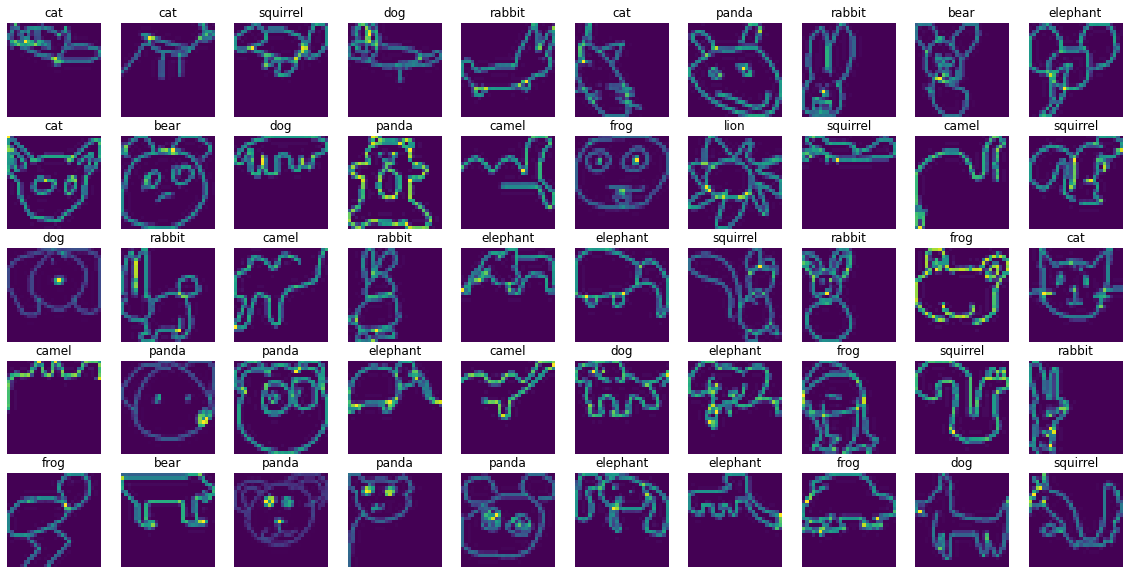

In [ ]:
# @title show sketch data image
def view_images_grid(X, y):
    """
    Function to plot grid with several examples of images.
    INPUT:
        X - (numpy array) images dataset
        y - (numpy array) labels for images from X dataset

    OUTPUT: None
    """
    fig, axs = plt.subplots(5, 10, figsize=(20,10))
    
    for label_num in range(0,50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 10
        j = label_num % 10
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(label_dict[y[r_label]])
    plt.show()

view_images_grid(X, y)

In [ ]:
## sketch based on LeNet 
def resize(x, kernel_size, dilation, stride, padding):
    x = int(1 + (x + 2*padding - dilation * (kernel_size - 1) - 1)/stride)
    return x
class LeNet(nn.Module):
    def __init__(self, specs, dropout=0.0):
        super(LeNet, self).__init__()
        self.specs = specs
        H, W, C0, C1, C2, kernel_size, F1, F2, nDigits, padding = specs
        pooling = 2
        #pooling = 1 # skips pooling
        stride = 1
        dilation = 1

        #self.pool = pool = nn.AvgPool2d(pooling)
        self.pool = pool = nn.MaxPool2d(pooling)
        
        self.conv1 = nn.Conv2d(C0, C1, kernel_size, padding=padding)
        # in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2
        #self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        H = resize(H, kernel_size, dilation, stride, padding)
        W = resize(W, kernel_size, dilation, stride, padding)

        H = resize(H, pooling, dilation, pooling, 0)
        W = resize(W, pooling, dilation, pooling, 0)

        self.conv2 = nn.Conv2d(C1, C2, kernel_size, padding=padding)

        H = resize(H, kernel_size, dilation, stride, padding)
        W = resize(W, kernel_size, dilation, stride, padding)

        H = resize(H, pooling, dilation, pooling, 0)
        W = resize(W, pooling, dilation, pooling, 0)

        #print(H, W)
        size = H * W * C2

        self.linear0 = nn.Linear(size, F1)
        self.linear1 = nn.Linear(F1, F2)
        self.linear2 = nn.Linear(F2, nDigits)

        self.non_linear = nn.LeakyReLU(negative_slope=0.01)
        
        self.dropout = nn.Dropout(dropout)

        for p in self.parameters(): # optionally apply different randomization
            if p.dim() > 1:
                nn.init.kaiming_normal_(p)
                pass

    def forward(self, prev):
        nBatch = len(prev)
        #print(prev.shape)
        prev = self.conv1(prev)#
        prev = self.non_linear(prev)
        prev = self.dropout(prev)
        prev = self.pool(prev)

        prev = self.conv2(prev)
        prev = self.non_linear(prev)
        prev = self.dropout(prev)
        prev = self.pool(prev)

        prev = prev.view(nBatch, -1)
        #print(prev.shape)

        prev = self.linear0(prev)
        prev = self.non_linear(prev)
        prev = self.dropout(prev)

        prev = self.linear1(prev)
        prev = self.non_linear(prev)
        prev = self.dropout(prev)

        prev = self.linear2(prev)

        return prev
##
def build_model(input_size, output_size, hidden_sizes, dropout = 0.0):
    '''
    Function creates deep learning model based on parameters passed.

    INPUT:
        input_size, output_size, hidden_sizes - layer sizes
        dropout - dropout (probability of keeping a node)

    OUTPUT:
        model - deep learning model
    '''

    # Build a feed-forward network
    #modelCNN = CNNModel()

    H=28    # don't change -- actual images are 28x28, not 32x32 -- H = height of image
    W=28    # don't change -- actual images are 28x28, not 32x32 -- W = width of image
    C0=1    # don't change -- # input channels -- 1 gray scale channel
    C1=6
    C2=16
    kernel_size=5
    F1 = 120
    F2 = 84
    nDigits=10    # don't change -- # outputs -- 10 digits
    padding=2
    specs = [H, W, C0, C1, C2, kernel_size, F1, F2, nDigits, padding]
    modelLeNet = LeNet(specs, dropout=0.1)
    
    return modelLeNet

def shuffle(X_train, y_train):
    """
    Function which shuffles training dataset.
    INPUT:
        X_train - (tensor) training set
        y_train - (tensor) labels for training set

    OUTPUT:
        X_train_shuffled - (tensor) shuffled training set
        y_train_shuffled - (tensor) shuffled labels for training set
        """
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0, optimizer = 'SGD'):
    """
    Function which fits the model.
    INPUT:
        model - pytorch model to fit
        X_train - (tensor) train dataset
        y_train - (tensor) train dataset labels
        epochs - number of epochs
        n_chunks - number of chunks to cplit the dataset
        learning_rate - learning rate value

    OUTPUT: None
    """
    print("Fitting model with epochs = {epochs}, learning rate = {lr}\n".format(epochs = epochs, lr = learning_rate))
    

    criterion = nn.CrossEntropyLoss()

    if (optimizer == 'SGD'):
      optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 10

    steps = 0

    for e in range(epochs):
        running_loss = 0
        X_train, y_train = shuffle(X_train, y_train)

        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1

            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if epochs % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            running_loss = 0

                            
def view_classify(img, ps):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
    """
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(["bear","camel","cat","dog","elephant","frog","lion","panda","rabbit","squirrel"], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()


def test_model(model, img):
    """
    Function creates test view of the model's prediction for image.

    INPUT:
        model - pytorch model
        img - (tensor) image from the dataset

    OUTPUT: None
    """

    # Convert 2D image to 1D vector
    img = img.resize_(1, 784)

    ps = get_preds(model, img)
    view_classify(img.resize_(1, 28, 28), ps)


def get_preds(model, input):
    """
    Function to get predicted probabilities from the model for each class.

    INPUT:
        model - pytorch model
        input - (tensor) input vector

    OUTPUT:
        ps - (tensor) vector of predictions
    """

    # Turn off gradients to speed up this part
    with torch.no_grad():
        logits = model.forward(input)
    ps = F.softmax(logits, dim=1)
    return ps

def get_labels(pred):
    """
        Function to get the vector of predicted labels for the images in
        the dataset.

        INPUT:
            pred - (tensor) vector of predictions (probabilities for each class)
        OUTPUT:
            pred_labels - (numpy) array of predicted classes for each vector
    """

    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels
def evaluate_model(model, train, y_train, test, y_test):
    """
    Function to print out train and test accuracy of the model.

    INPUT:
        model - pytorch model
        train - (tensor) train dataset
        y_train - (numpy) labels for train dataset
        test - (tensor) test dataset
        y_test - (numpy) labels for test dataset

    OUTPUT:
        accuracy_train - accuracy on train dataset
        accuracy_test - accuracy on test dataset
    """
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {} \n".format(accuracy_train))
    print("Accuracy score for test set is {} \n".format(accuracy_test))

    return accuracy_train, accuracy_test

def plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = 0.003, weight_decay = 0.0, dropout = 0.0, n_chunks = 1000, optimizer = 'SGD'):
    """
    Function to plot learning curve depending on the number of epochs.

    INPUT:
        input_size, output_size, hidden_sizes - model parameters
        train - (tensor) train dataset
        labels - (tensor) labels for train dataset
        y_train - (numpy) labels for train dataset
        test - (tensor) test dataset
        y_test - (numpy) labels for test dataset
        learning_rate - learning rate hyperparameter
        weight_decay - weight decay (regularization)
        dropout - dropout for hidden layer
        n_chunks - the number of minibatches to train the model
        optimizer - optimizer to be used for training (SGD or Adam)

    OUTPUT: None
    """
    train_acc = []
    test_acc = []

    for epochs in np.arange(10, 60, 10):
        # create model
        sketch_model = build_model(input_size, output_size, hidden_sizes, dropout = dropout)

        # fit model
        fit_model(sketch_model, train, labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay, optimizer = 'SGD')
        # get accuracy
        accuracy_train, accuracy_test = evaluate_model(sketch_model, train, y_train, test, y_test)

        train_acc.append(accuracy_train)
        test_acc.append(accuracy_test)

    
    return train_acc, test_acc, sketch_model

In [ ]:
## My trial:
import numpy as np
import pandas as pd
from PIL import Image
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.dataset import Dataset
###############################################################################
import time, os, sys, random, datetime
use_cuda = torch.cuda.is_available()
L2_lambda = 0.001
global nEpochs
nEpochs = 2
nEpochs = 50

log_interval = 100
#log_interval = 10
learning_rate = 0.00005  # default

class DatasetFromCSV(Dataset):
    def __init__(self,datas,labels,height,width,transforms=None):
        #self.data = pd.read_csv(csv_path)
        self.data = datas
        self.labels = labels
        #view_images_grid(self.data, self.labels)
        self.height = height
        self.width = width
        self.transforms = transforms
 
    def __getitem__(self, index):
        single_image_label = self.labels[index]
        '''
        # lzx's trial:(把getitem都打出来吧mlgbz)
        lzx_image=self.data[index].reshape(28,28)
        #fig,axs=plt.subplots(1,1,figsize=(5,5))
        plt.imshow(lzx_image)
        plt.title(label_dict[self.labels[index]],loc="left")
        plt.show()
        # mlgbz
        '''
        # 读取所有像素值，并将 1D array ([784]) reshape 成为 2D array ([28,28])
        #img_as_np = np.asarray(self.data[index][:]).reshape(28, 28).astype(float)
        img_as_np = np.asarray(self.data[index]).reshape(28, 28).astype(float)
        # 把 numpy array 格式的图像转换成灰度 PIL image
        img_as_img = Image.fromarray(img_as_np)
        #img_as_img = img_as_img.convert('L')
        # 将图像转换成 tensor
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
            # 返回图像及其 label
        return (img_as_tensor, single_image_label)
 
    def __len__(self):
        #datacopy=self.data.copy().tolist()
        #return len(datacopy.index)
        return len(self.data)
 
def cuda(arr):
    if use_cuda:
      return arr.cuda()
    return arr
def train_LeNet(model, train_loader, test_loader):
    if use_cuda:
        model = model.cuda()

    # define the loss functions
    criterion = nn.CrossEntropyLoss(reduction='sum')

    # choose an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2_lambda)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=L2_lambda)
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=L2_lambda)
    #optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate, weight_decay=L2_lambda)

    start = time.time()
    w_decay = 0.95 # smoothing factor for reporting results
    for e in range(nEpochs):
        total_train_images = 0
        total_train_loss = 0
        train_images = 0
        train_loss = 0
        w_images = 0
        w_loss = 0

        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = cuda(data), cuda(target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_images += len(data)
            train_loss += loss.data.item()

            if train_images > log_interval:
                total_train_images += train_images
                total_train_loss += train_loss
                if w_images == 0:
                    w_loss = train_loss
                    w_images = train_images
                else:
                    w_images = w_decay * w_images + train_images
                    w_loss = w_decay * w_loss + train_loss
                
                print("epoch %3d total train images: %8d loss: %8.3f loss: %8.3f     time: %6.1f" % (e, total_train_images, train_loss/train_images, w_loss/w_images, (time.time()-start)))

                train_images = 0
                train_loss = 0
                #break

        test_images = 0
        test_loss = 0
        nCorrect = 0
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = cuda(data), cuda(target)
                output = model(data)
                loss = criterion(output, target)

                test_images += len(data)
                test_loss += loss.data.item()
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max value
                nCorrect += pred.eq(target.view_as(pred)).sum().item() # count correct items
        print("================================================================================================")
        print("%3d %8d %8.3f %8.3f %8.3f %8.1f%%     %6.1f" % (e, (e+1)*total_train_images, total_train_loss/total_train_images, w_loss/w_images, test_loss/test_images, 100*nCorrect/test_images, (time.time()-start)))
        print("================================================================================================")

    return model

batch_size = 10
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

# Split dataset into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)
'''
print("have a look!")
view_images_grid(X_train, y_train)
view_images_grid(X_test, y_test)
'''
train_data= DatasetFromCSV(X_train,y_train,28,28,transform)
test_data = DatasetFromCSV(X_test,y_test,28,28,transform)
 
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size)

H=28    # don't change -- actual images are 28x28, not 32x32 -- H = height of image
W=28    # don't change -- actual images are 28x28, not 32x32 -- W = width of image
C0=1    # don't change -- # input channels -- 1 gray scale channel
C1=26
C2=32
kernel_size=5
F1 = 120
F2 = 84
nDigits=10    # don't change -- # outputs -- 10 digits
padding=0

#C1 = 20
#padding = 1

specs = [H, W, C0, C1, C2, kernel_size, F1, F2, nDigits, padding]
model = LeNet(specs, dropout=0.1)
print(model)
model = train_LeNet(model,train_loader,test_loader)


流式输出内容被截断，只能显示最后 5000 行内容。
epoch  24 total train images:     2090 loss:    1.156 loss:    1.257     time:  305.5
epoch  24 total train images:     2200 loss:    1.344 loss:    1.264     time:  305.5
epoch  24 total train images:     2310 loss:    1.361 loss:    1.271     time:  305.6
epoch  24 total train images:     2420 loss:    1.278 loss:    1.272     time:  305.6
epoch  24 total train images:     2530 loss:    1.204 loss:    1.267     time:  305.7
epoch  24 total train images:     2640 loss:    1.289 loss:    1.268     time:  305.8
epoch  24 total train images:     2750 loss:    1.132 loss:    1.259     time:  305.8
epoch  24 total train images:     2860 loss:    1.269 loss:    1.260     time:  305.9
epoch  24 total train images:     2970 loss:    1.070 loss:    1.247     time:  305.9
epoch  24 total train images:     3080 loss:    1.273 loss:    1.249     time:  306.0
epoch  24 total train images:     3190 loss:    1.408 loss:    1.259     time:  306.0
epoch  24 total train image